# Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. 
В нём можно быстро узнать рыночную стоимость своего автомобиля. 

- Предоставлены исторические данные: технические характеристики, комплектации и цены автомобилей. 
- Необходимо построить модель для определения стоимости.

Заказчику важны:
1. качество предсказания;
2. скорость предсказания;
3. время обучения.

# Описание данных

Данные находятся в файле /datasets/autos.csv 

## Признаки
1. DateCrawled — дата скачивания анкеты из базы -
1. VehicleType — тип автомобильного кузова
1. RegistrationYear — год регистрации автомобиля
1. Gearbox — тип коробки передач
1. Power — мощность (л. с.)
1. Model — модель автомобиля
1. Kilometer — пробег (км)
1. RegistrationMonth — месяц регистрации автомобиля -
1. FuelType — тип топлива
1. Brand — марка автомобиля
1. NotRepaired — была машина в ремонте или нет
1. DateCreated — дата создания анкеты -
1. NumberOfPictures — количество фотографий автомобиля - 
1. PostalCode — почтовый индекс владельца анкеты (пользователя)
1. LastSeen — дата последней активности пользователя -

## Целевой признак
1. Price — цена (евро)

# План


1. В качестве модели попробуем градиентный бустинг, линейную регрессию
2. Поэкспериментируем и сравним характеристики моделей: скорость работы, точность результата.

## Как реализуес

1. Загрузим и подготовим данные.
2. Обучите разные модели. Для каждой попробуйте различные гипепараметеры.
3. Проанализируйте скорость работы и качество моделей.
4. Для оценки качества моделей применим метрику RMSE.
5. Для построения модели градиентного бустинга попробуем библиотеку LightGBM и её средства.
6. Для оценки времени обучения моделииспользуем магическую команду Jupyter Notebook %%time
7. Поскольку модель градиентного бустинга может обучаться долго, изменим у неё только два-три параметра.

# 1 Подготовка

In [1]:
# подключаем библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, make_scorer

import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

import joblib

In [2]:
# определяем форматы вывода
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format

# 2 Подготовка данных

In [3]:
# загружаем таблицу с обучающими данными
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
except Exception as ex:
    print("Файл не загружается. Смотри ошибку: ", ex)

## 1.1 Посмотрим на данные

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Имеются излишние данные для моделирования. Их уберем сразу.

### 1. Удалим так как эти даты по смыслу не обладают предсказательной силой и будут создавать искажения при моделировании:

    - `DateCrawled` - "дата скачивания анкеты из базы"
    - `RegistrationMonth` — месяц регистрации автомобиля
    - `DateCreated`— дата создания анкеты
    - `LastSeen` - дата последней активности пользователя

In [5]:
delete_data = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'LastSeen']
data.drop(delete_data, axis=1, inplace=True)

### 2. Удалим дупликаты

In [6]:
print(data.duplicated().sum())
data.drop_duplicates(inplace=True)
print(data.duplicated().sum())

23511
0


### 3. Удалим столбец `NumberOfPictures` так как взе значениям там равны нулю

In [7]:
data.drop(['NumberOfPictures' ], axis=1, inplace=True)

### 4. Исследууем данные

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330858 entries, 0 to 354368
Data columns (total 11 columns):
Price               330858 non-null int64
VehicleType         294839 non-null object
RegistrationYear    330858 non-null int64
Gearbox             311998 non-null object
Power               330858 non-null int64
Model               311894 non-null object
Kilometer           330858 non-null int64
FuelType            299029 non-null object
Brand               330858 non-null object
NotRepaired         263235 non-null object
PostalCode          330858 non-null int64
dtypes: int64(5), object(6)
memory usage: 30.3+ MB


In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,"330,858.00","4,381.80","4,506.41",0.00,"1,000.00","2,699.00","6,300.00","20,000.00"
RegistrationYear,"330,858.00","2,004.18",89.51,"1,000.00","1,999.00","2,003.00","2,008.00","9,999.00"
Power,"330,858.00",109.80,194.86,0.00,68.00,103.00,140.00,"20,000.00"
Kilometer,"330,858.00","128,253.07","37,943.15","5,000.00","125,000.00","150,000.00","150,000.00","150,000.00"
PostalCode,"330,858.00","50,711.28","25,812.49","1,067.00","30,179.00","49,492.00","71,364.00","99,998.00"


#### Проанализируем гистораммы, ящики с усами числовых данных, зависимости переменных

In [10]:
# Создадим список числовых параметров
list_feather = data.select_dtypes(exclude='object').columns.tolist()

In [11]:
# функция для гистограмм
def hist(data, list_feather):
    fig, ax = plt.subplots(1, len(list_feather),figsize=(4*len(list_feather), 4))
    for i, param in enumerate(list_feather):
        Q1 = data[param].quantile(0.25)
        Q3 = data[param].quantile(0.75)
        IQR = Q3 - Q1
        a = Q1-3*IQR
        b = Q3+3*IQR
        filtered = data[param][(data[param] >= a) & (data[param] < b)]
        sns.distplot(
            filtered,
            bins=55,
            hist=True,
            kde=False,
            hist_kws={"range": [a,b]},
            label=param,
            ax=ax[i]
        )

# функция для боксплотов
def box_pl(data, list_feather):
    fig, ax = plt.subplots(1, len(list_feather),figsize=(4*len(list_feather), 4))
    for i, param in enumerate(list_feather):
        Q1 = data[param].quantile(0.25)
        Q3 = data[param].quantile(0.75)
        IQR = Q3 - Q1
        a = Q1-1.5*IQR
        b = Q3+1.5*IQR
        print('|',Q1,Q3,IQR, int(a), int(b), '|', end=' ' )
        filtered = data[param][(data[param] >= a) & (data[param] < b)]
        sns.boxplot(
            filtered,
            ax=ax[i]
        )
        plt.ylim([a,b])

# функция для для выявления корреляции параметров
def corr_func_platform(df, list_platform):
    pd.plotting.scatter_matrix(data[list_platform], figsize=(10, 10))
    plt.suptitle("Зависимость продаж игр на платформе ",  fontsize=15)
    plt.show()
    display(data[list_platform].corr())

| 1000.0 6300.0 5300.0 -6950 14250 | | 1999.0 2008.0 9.0 1985 2021 | | 68.0 140.0 72.0 -40 248 | | 125000.0 150000.0 25000.0 87500 187500 | | 30179.0 71364.0 41185.0 -31598 133141 | 

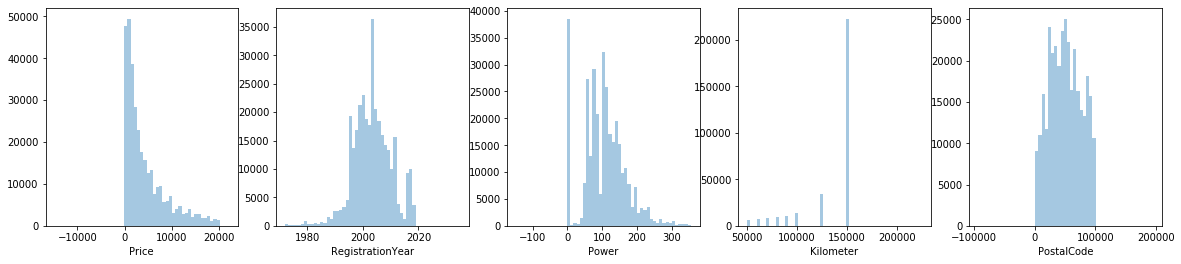

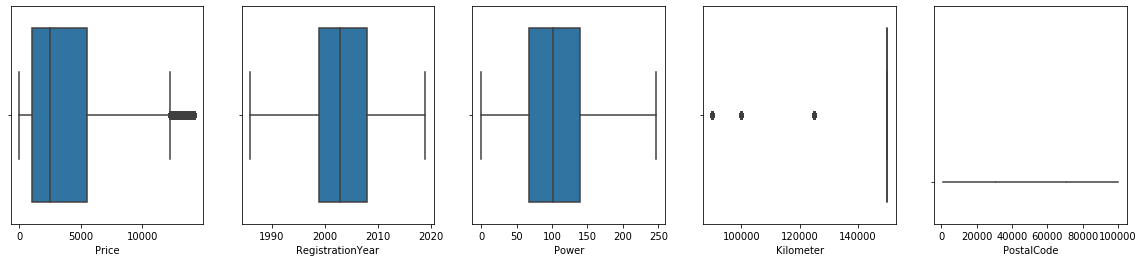

In [12]:
# Вызовим функции для построению гистограмм, боксплотов, корреляции
hist(data, list_feather)
box_pl(data, list_feather)

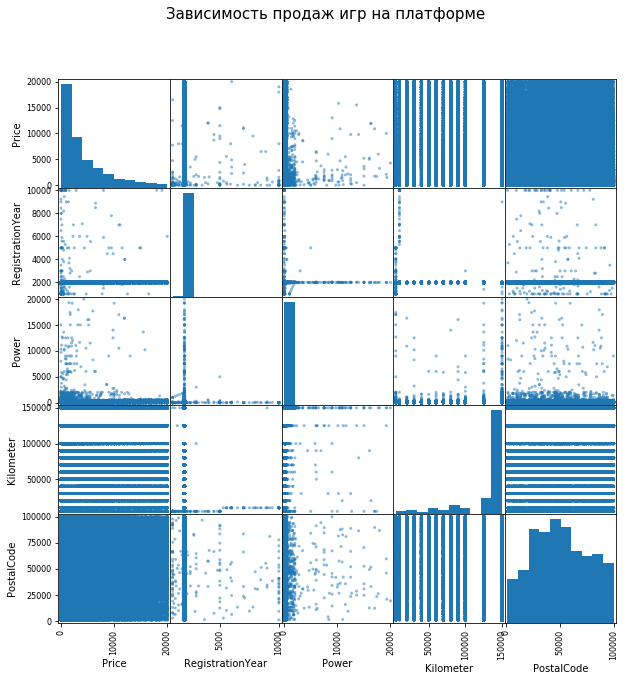

,Price,RegistrationYear,Power,Kilometer,PostalCode
Price,1.00,0.03,0.15,-0.33,0.08
RegistrationYear,0.03,1.00,-0.00,-0.05,-0.00
Power,0.15,-0.00,1.00,0.02,0.02
Kilometer,-0.33,-0.05,0.02,1.00,-0.01
PostalCode,0.08,-0.00,0.02,-0.01,1.00


In [13]:
corr_func_platform(data, list_feather)

##### Выводы:
1. Поле `Price`.
    - судя по гистограмме цена варьируется от нуля до 20 тыс евро. Существенное колличество цен за 0 евро, что странно.
    - судя по блокбоксу аномальные значения начинаются после приблизительно 14.5 тыс. евро.
    - судя по матрице корреляции существенных зависимостей нет
    - Удалим эекспертно объекты с ценой до 500 евро, дешевле авто на рынке яявно фейк. Высокие цены ограничивать не будем так как цены до 20 тыс евро не похожи на аномальные, а лиш кажуться несколько выше остальных.
1. Поле `RegistrationYear`. судя по describe минимальные значения равны 1000, что аномально. по блокбоксу левый ус ограничивается годом 1985 им и ограничимся слева, справа - 2020 год.
1. Поле `Power`. Есть всплеск на мощности равный ноль. Экспертно ограничим мощность "слева" 40 л.с. , справа ограничим правым усом равным 300 л.с.
1. Поле `Kilometer`. Ограничивать не будем. хотя конечно странно что большенство значений равно в 150 тыс км. Видимо особенность формы для заполненияя данных. Ограничивать не будем. 
1. Поле `PostalCode` модифицировать не будем. 




##### Действия в следствии выводов

In [14]:
#### Поле Price. Удаляем объекты с ценой меньше 500 евро
data.drop(data.loc[data['Price'] < 500].index , axis=0, inplace=True)

In [15]:
#### Поле RegistrationYear. Удаляем объекты с годом меньше 1985 и больше 2020
data.drop(data.loc[(data['RegistrationYear'] < 1985) | (data['RegistrationYear'] > 2020)].index , inplace=True)

In [16]:
#### Поле Power. Удаляем объекты с годом меньше 40 и больше 300
data.drop(data.loc[(data['Power'] < 40) | (data['Power'] > 300)].index , inplace=True)

In [17]:
data.shape

(262170, 11)

#### Проверим данные на пропуски

In [18]:
list_name_column_nan = data.loc[:, data.isnull().any()].copy().columns.tolist()
print('количество пропусков, %:', '\n', '\n' , round(data[list_name_column_nan].isna().sum()/len(data)*100,1))

количество пропусков, %: 
 
 VehicleType    6.60
Gearbox        1.80
Model          3.60
FuelType       6.00
NotRepaired   14.40
dtype: float64


##### Удалим пропуски по столбцам `Gearbox`, `Model`, `FuelType` так как заменить не чем  

In [19]:
data.dropna(subset=['Gearbox'],  inplace=True)
data.dropna(subset=['Model'],  inplace=True)
data.dropna(subset=['FuelType'],  inplace=True)
data.shape

(236117, 11)

##### Nan в `VehicleType` заменим на 'unspecified'    

In [20]:
data.fillna('unspecified', inplace=True)

##### Еще раз проверим на пропуски 

In [21]:
list_name_column_nan = data.loc[:, data.isnull().any()].copy().columns.tolist()
print(round(data[list_name_column_nan].isna().sum()/len(data)*100,1))
data.shape

Series([], dtype: float64)


(236117, 11)

# 3 Обучение моделей

## Подготовка данных

### Преобразование кактегориальных признаков в численные методом прямого кодирования

In [22]:
data2 = data.copy()

list_feather.remove('Price')
cat_features = ['VehicleType', 'Gearbox', 'Model',
                'FuelType', 'Brand', 'NotRepaired']

data_boost = pd.get_dummies(data2, columns=cat_features, drop_first=True)
data_ohe = data2

### Разбиение датасета на тренировучную, валидационную и тестовую

In [23]:
# Перемешиваем строчки
data_boost = shuffle(data_boost)
#data_ohe = shuffle(data_ohe)

# разделяем датасет
df_train, df_valid_test = train_test_split(data_boost, test_size=0.5, random_state=12345)
df_valid, df_test = train_test_split(df_valid_test, test_size=0.5, random_state=12345)

features_train = df_train.drop('Price',axis=1)
features_valid = df_valid.drop('Price',axis=1) 
features_test = df_test.drop('Price',axis=1) 

target_train = df_train['Price'] 
target_valid = df_valid['Price']
target_test = df_test['Price'] 

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(118058, 306)
(59029, 306)
(59030, 306)


In [24]:
scaler = StandardScaler()
scaler.fit(features_train[list_feather])

features_train[list_feather] = scaler.transform(features_train[list_feather])
features_valid[list_feather] = scaler.transform(features_valid[list_feather])
features_test[list_feather] = scaler.transform(features_test[list_feather])

features_train.head()

,RegistrationYear,Power,Kilometer,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unspecified,VehicleType_wagon,Gearbox_manual,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unspecified,NotRepaired_yes
148180,0.22,-1.67,0.60,-0.99,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Обучаем модель (ленейную регрессию) на тренировочной выборке 

In [25]:
%%time
# обучаем для предсказания @target_train
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
model_lr_predict = model_lr.predict(features_valid)

RMSE = mean_squared_error(model_lr_predict, target_valid)**0.5
print('RMSE =', RMSE)

RMSE = 2268.7986924853
CPU times: user 9.52 s, sys: 2.89 s, total: 12.4 s
Wall time: 12.4 s


In [26]:
# предсказываем и проверяем обученную модель на @target_test
model_lr_predict_test = model_lr.predict(features_test)

RMSE = mean_squared_error(model_lr_predict_test, target_test)**0.5
print('RMSE =', RMSE)

RMSE = 2286.809185921828


### Обучаем модель CatBoostRegressor на тренировочной выборке 

In [27]:
%%time
model_catb = CatBoostRegressor() 

parameters = {'depth'        : [6,8,10],
            'learning_rate'  : [0.1, 0.4, 0.7],
            'iterations'     : [30, 50, 100]
                }
# Создадим функцию для расчета RMSE

def rmse_score(predictions, targets,  sample_weight=None, multioutput='raw_values'):
    return np.sqrt(mean_squared_error(predictions, targets, sample_weight, multioutput))


grid_catb = GridSearchCV(estimator=model_catb, param_grid=parameters, scoring=make_scorer(rmse_score), cv=5, n_jobs=-1)
grid_catb.fit(features_train, target_train,  verbose=0) 

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
print("\n The best score across ALL searched params:\n",
        grid_catb.best_score_)
print("\n The best parameters across ALL searched params:\n",
        grid_catb.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best score across ALL searched params:
 1959.987567312618

 The best parameters across ALL searched params:
 {'depth': 6, 'iterations': 30, 'learning_rate': 0.1}

CPU times: user 21min 26s, sys: 2min 21s, total: 23min 48s
Wall time: 27min 2s


RMSE приемлемо. Приблизительно в два раза меньше стандартного отклонением `Price`=4.506

In [28]:
# предсказываем и проверяем обученную модель на @target_test
model_catb_predict_test = grid_catb.predict(features_test)

RMSE = mean_squared_error(model_catb_predict_test, target_test)**0.5
print('RMSE =', RMSE)

RMSE = 1968.3339229553837


Округлим до 1968

(было 1980.81)

Предсказание на тестовых данных почти такое же как и на валидационных. Модель не переобучена

### Обучаем модель LGBMRegressor на тренировочной выборке 

In [ ]:
features_train[cat_features] = features_train[cat_features].astype('category')

Не сработало(

In [30]:
%%time
model_lgbmr = LGBMRegressor()

grid_lgbmr = GridSearchCV(model_lgbmr, parameters, scoring=make_scorer(rmse_score), n_jobs=-1, cv=5)
grid_lgbmr.fit(features_train, target_train,  verbose=0)

# summarize results
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
print("\n The best score across ALL searched params:\n",
        grid_lgbmr.best_score_)
print("\n The best parameters across ALL searched params:\n",
        grid_lgbmr.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best score across ALL searched params:
 1579.6453616950284

 The best parameters across ALL searched params:
 {'depth': 6, 'iterations': 30, 'learning_rate': 0.1}

CPU times: user 14min 8s, sys: 24 s, total: 14min 32s
Wall time: 14min 41s


RMSE приемлемо. Приблизительно в два раза меньше стандартного отклонением `Price`=4.506

In [ ]:
features_test[cat_features] = features_test[cat_features].astype('category')

Тут также

In [33]:
# предсказываем и проверяем обученную модель на @target_test
model_lgbmr_predict_test = grid_lgbmr.predict(features_test) 
model_lgbmr_predict_test = model_lgbmr_predict_test 
RMSE = mean_squared_error(model_lgbmr_predict_test, target_test)**0.5
print('RMSE =', RMSE)

RMSE = 1586.8027804028798


Предсказание на тестовых данных почти такое же как и на валидационных. Модель не переобучена

### Проверяем адекватность модели на константной модели (медианы таргетов на тестовой выборке)

In [ ]:
%%time
predict_median = pd.Series(target_valid.median(), index=target_valid.index)
const_model = mean_squared_error(target_valid, predict_median)**0.5
print('RMSE константной модели', const_model)

RMSE константной модели примерно равно стандартному отклонению `Price`=4.506. У всех моделей предсказания лучше чем у константной , значит с ними можно работать, они адекватные.

# 4 Анализ моделей

1. Простейшая модель линейная регрессия дала следующие показатели:
    1. RMSE = 2275
    2. Время обучения = 16 сек 
2. Модель CatBoostRegressor дала следующие показатели
    1. RMSE = 1969
    2. Время обучения = 27 мин 
    3. Лучшие гиперпараметры 
        - 'depth': 6, 
        - 'iterations': 30, 
        - 'learning_rate': 0.1
2. Модель LGBMRegressor дала следующие показатели
    1. RMSE = 1592
    2. Время обучения = 15 мин
    3. Лучшие гиперпараметры 
        - 'depth': 6, 
        - 'iterations': 30, 
        - 'learning_rate': 0.1
         



## Промежуточные выводы

Общие:
1. Модели обучены на тренировочных данных. 
2. Проверено качество моделей метрикой RMSE, каждая модель дала значения в пределах стандартного отклонения целевого параметра `Price`, что неплохо. 
3. Предсказания на отложенной тестовой выборке дало немногим хуже результат на валидационной выборке. Можно сказать, чьто модели не переобучены.
4. Выполнено сравение предсказаний полученных моделей с константными аналагоми. Результаты всех трех моделей оказались лучше. 

Сутевые:
1. Лучшее время обучения было у линейной регрессии = 16 сек
2. RMSE между двумя моделями с градиентным бустингом вышло примерно одинаковое, но у LGBMRegressor немного лучше = 1592. У простейшей линейно регрессии существенно хуже.
3. Лачшие гиперпараметры у градиентных моделей оказались одинаковыми 'depth': 6, 'iterations': 30, 'learning_rate': 0.1


# Итоги
1. По качеству предсказания цены автомобилей выше всего у LGBMRegressor, и скорость на втором месте после лин регрессии.  Скорость выше всех соответственно у линейной регрессии. Если нужна скорость можно рекоммендовать лин регрессию. Если надо поточнее, то LGBMRegressor. 

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей